# Cancer Tissue Detection using CNN

Installing Required libraries
Step 1.1- Please refer to the "Technical Requirements" section in the book for the neccessary packages to be installed. Please note that chapter has differnt Pytorch Lightning version and thus diff torch dependancies. Some functions may not work with other versions than what is tested below, so please ensure correct versions.

In [1]:
#Step1 Please refer to the "Technical Requirements" section in the book for the neccessary packages to be installed here
!pip install torch==1.10.0 torchvision==0.11.1 torchtext==0.11.0 torchaudio==0.10.0 --quiet
!pip install pytorch-lightning==1.5.2 --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 2.10.0 requires protobuf<5.0.0dev,>=3.20.1, but you have protobuf 3.19.4 which is incompatible.


In [2]:
!pip install opendatasets --upgrade --quiet

## Step 1.2 Import the neccessary packages. Please refer to the section, Importing the packages in the book for further details.

In [1]:
#refer to book for correct version of package and import here
import os
import shutil
import opendatasets as od
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchmetrics.functional import accuracy
import pytorch_lightning as pl

In [2]:
print("pandas version:",pd.__version__)
print("numpy version:",np.__version__)
#print("seaborn version:",sns.__version__)
print("torch version:",torch.__version__)
print("pytorch ligthening version:",pl.__version__)

pandas version: 1.4.2
numpy version: 1.21.5
torch version: 1.10.0
pytorch ligthening version: 1.5.2


## Step 2.1 - Load the dataset- Please refer to the book in section "collecting the dataset" for the proper way to collect the dataset and steps to import it.

In [3]:
cancer_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
cancer_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
cancer_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [5]:
print('No. of images in training dataset: ', len(os.listdir("histopathologic-cancer-detection/train")))
print('No. of images in testing dataset: ', len(os.listdir("histopathologic-cancer-detection/test")))

No. of images in training dataset:  220025
No. of images in testing dataset:  57458


In [6]:
# Setting seed to make the results replicable
np.random.seed(0)
train_imgs_orig = os.listdir("histopathologic-cancer-detection/train")
selected_image_list = []
for img in np.random.choice(train_imgs_orig, 10000):
  selected_image_list.append(img)
len(selected_image_list)

10000

In [11]:
selected_image_list[0]

'89bb7789aa5961825fa0d748dde3c9aa141f71d3.tif'

In [7]:
enumeration = enumerate(np.random.choice(selected_image_list, 20))

In [10]:
np.random.choice(selected_image_list, 20)

array(['da6a487437ecd8f49766363b6e35d38774701ca6.tif',
       'e3213e230bf3a85b4a9ed75111f1abe6413aecec.tif',
       '39aa2bd5f8d1c94db782109e4ab6d3ed6a22757d.tif',
       '6cf704faf4924e4f3bdfa91daa127363f413a98b.tif',
       '74711d678288a02d88fc37089a298e072e323430.tif',
       'fda0a65a2256f6e9987f0fbe7270c8007056987e.tif',
       'a95227daf851c0fa69fab87735a7928f1a87f679.tif',
       '6cf07c05a749b4cc260c1beab220b8143ddbb80c.tif',
       'f22c0c19383df0172c1c70dc0e7e51ebb8bdda0b.tif',
       '5c645592ef4f4c4ad724ab0797ad9a9c616bd65c.tif',
       '31a1eb9e83d5ba67f220fabfa97285d82a449bcf.tif',
       '41f7ad48c4e9b55942dea8d8763faba56e0ba0e3.tif',
       'f03ada45734f6b24857fc9bef4628ef903c3121b.tif',
       '650c1d3345d4bdf08de51eb85d9b1bc315f886c2.tif',
       'a40999583f2ff83997459121441f55fcd1b857a2.tif',
       '1b2b848b99a95d92691b40ccdbbdd97970fedc1e.tif',
       '4b288c3e4c5d4589c2677358f44ed91f40a81a39.tif',
       '28a34e19307138ab2a77e1edcf4ab93be5807998.tif',
       '71

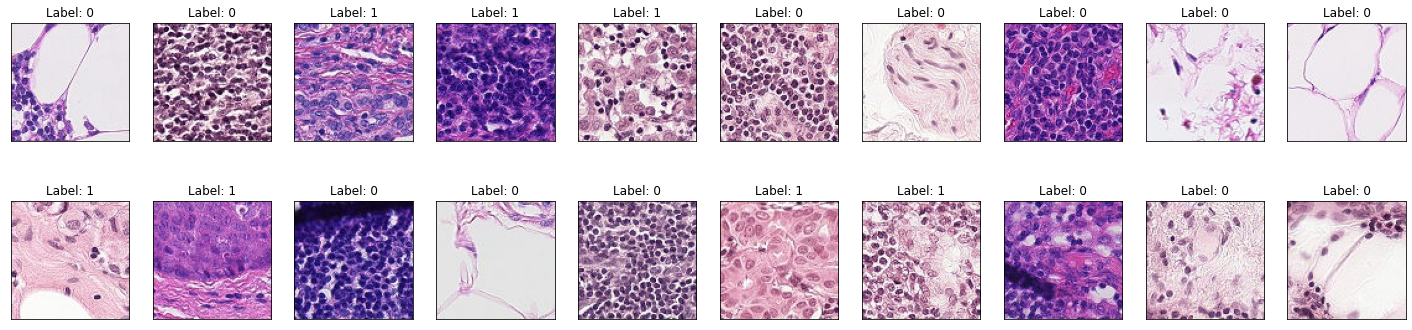

In [11]:
fig = plt.figure(figsize=(25, 6))
for idx, img in enumerate(np.random.choice(selected_image_list, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("histopathologic-cancer-detection/train/" + img)
    plt.imshow(im)
    lab = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

In [12]:
np.random.seed(0)
np.random.shuffle(selected_image_list)
cancer_train_idx = selected_image_list[:8000]
cancer_test_idx = selected_image_list[8000:]
print("Number of images in the downsampled training dataset: ", len(cancer_train_idx))
print("Number of images in the downsampled testing dataset: ", len(cancer_test_idx))

Number of images in the downsampled training dataset:  8000
Number of images in the downsampled testing dataset:  2000


In [16]:
data_T_train = T.Compose([
    T.CenterCrop(32),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    ])


In [17]:
data_T_test = T.Compose([
    T.CenterCrop(32),
    T.ToTensor(),
    ])

In [18]:
# Extracting the labels for the images that were selected in the downsampled data
selected_image_labels = pd.DataFrame()
id_list = []
label_list = []

for img in selected_image_list:
  label_tuple = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0]]
  id_list.append(label_tuple['id'].values[0])
  label_list.append(label_tuple['label'].values[0])

In [19]:
selected_image_labels['id'] = id_list
selected_image_labels['label'] = label_list
selected_image_labels.head()

,id,label
0,a073b541e2b18fa4da6b4e2f755f79cc347fb021,1
1,77885c592d14ec1f32bb315db1e535a027baa187,0
2,14fff01bb0a6b5c82acc5377f9b34a80da9b71e0,1
3,8a9cbb87d33e7a699cb6d9550b3403739622a1fb,1
4,0b7edcd3569c69c49fdc98c8f5d07ec678eadd2b,0


In [20]:
# dictionary with labels and ids of train data
img_label_dict = {k:v for k, v in zip(selected_image_labels.id, selected_image_labels.label)}

In [21]:
class LoadCancerDataset(Dataset):
    def __init__(self, data_folder, 
                 transform = T.Compose([T.CenterCrop(32),T.ToTensor()]), dict_labels={}):
        self.data_folder = data_folder
        self.list_image_files = [s for s in os.listdir(data_folder)]
        self.transform = transform
        self.dict_labels = dict_labels
        self.labels = [dict_labels[i.split('.')[0]] for i in self.list_image_files]

    def __len__(self):
        return len(self.list_image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_folder, self.list_image_files[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        img_name_short = self.list_image_files[idx].split('.')[0]

        label = self.dict_labels[img_name_short]
        return image, label

In [23]:
%%time
# Load train data 
train_set = LoadCancerDataset(data_folder='histopathologic-cancer-detection/train_dataset/', 
                        # datatype='train', 
                        transform=data_T_train, dict_labels=img_label_dict)

CPU times: user 7.89 ms, sys: 16.2 ms, total: 24.1 ms
Wall time: 23.5 ms


In [25]:
os.mkdir('histopathologic-cancer-detection/test_dataset/')
for fname in cancer_test_idx:
  src = os.path.join('histopathologic-cancer-detection/train', fname)
  dst = os.path.join('histopathologic-cancer-detection/test_dataset/', fname)
  shutil.copyfile(src, dst)
print('No. of images in downsampled testing dataset: ', len(os.listdir("histopathologic-cancer-detection/test_dataset/")))

No. of images in downsampled testing dataset:  1989


In [26]:
test_set = LoadCancerDataset(data_folder='histopathologic-cancer-detection/test_dataset/', 
                         transform=data_T_test, dict_labels=img_label_dict)

In [29]:
batch_size = 256

train_dataloader = DataLoader(train_set, batch_size, num_workers=2, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size, num_workers=2, pin_memory=True)

In [33]:
class CNNImageClassifier(pl.LightningModule):

    def __init__(self, learning_rate = 0.001):
        super().__init__()

        self.learning_rate = learning_rate

        self.conv_layer1 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv_layer2 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.fully_connected_1 =nn.Linear(in_features=16 * 16 * 6,out_features=1000)
        self.fully_connected_2 =nn.Linear(in_features=1000,out_features=500)
        self.fully_connected_3 =nn.Linear(in_features=500,out_features=250)
        self.fully_connected_4 =nn.Linear(in_features=250,out_features=120)
        self.fully_connected_5 =nn.Linear(in_features=120,out_features=60)
        self.fully_connected_6 =nn.Linear(in_features=60,out_features=2)
        self.loss = nn.CrossEntropyLoss()
        self.save_hyperparameters()

    def forward(self, input):
        output=self.conv_layer1(input)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv_layer2(output)
        output=self.relu2(output)
        output=output.view(-1, 6*16*16)
        output = self.fully_connected_1(output)
        output = self.fully_connected_2(output)
        output = self.fully_connected_3(output)
        output = self.fully_connected_4(output)
        output = self.fully_connected_5(output)
        output = self.fully_connected_6(output)
        return output

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs) 
        train_accuracy = accuracy(outputs, targets)
        loss = self.loss(outputs, targets)
        self.log('train_accuracy', train_accuracy, prog_bar=True)
        self.log('train_loss', loss)
        return {"loss":loss, "train_accuracy":train_accuracy}

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        test_accuracy = accuracy(outputs, targets)
        loss = self.loss(outputs, targets)
        self.log('test_accuracy', test_accuracy)
        return {"test_loss":loss, "test_accuracy":test_accuracy}

    def configure_optimizers(self):
        params = self.parameters()
        optimizer = optim.Adam(params=params, lr = self.learning_rate)
        return optimizer

    # Calculate accuracy for each batch at a time
    def binary_accuracy(self, outputs, targets):
        _, outputs = torch.max(outputs,1)
        correct_results_sum = (outputs == targets).sum().float()
        acc = correct_results_sum/targets.shape[0]
        return acc

    def predict_step(self, batch, batch_idx ):
        return self(batch)

In [35]:
model = CNNImageClassifier()

trainer = pl.Trainer(fast_dev_run=True, gpus=0)
trainer.fit(model, train_dataloaders=train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).

   | Name              | Type             | Params
--------------------------------------------------------
0  | conv_layer1       | Conv2d           | 84    
1  | relu1             | ReLU             | 0     
2  | pool              | MaxPool2d        | 0     
3  | conv_layer2       | Conv2d           | 168   
4  | relu2             | ReLU             | 0     
5  | fully_connected_1 | Linear           | 1.5 M 
6  | fully_connected_2 | Linear           | 500 K 
7  | fully_connected_3 | Linear           | 125 K 
8  | fully_connected_4 | Linear           | 30.1 K
9  | fully_connected_5 | Linear           | 7.3 K 
10 | fully_connected_6 | Linear           | 122   
11 | loss              | CrossEntropyLoss | 0     
--------------------------------------------------------
2.2 M    

Training: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/gaetanbrison/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/gaetanbrison/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'LoadCancerDataset' on <module '__main__' (built-in)>
/Users/gaetanbrison/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [37]:
# trainer.test(test_dataloaders=test_dataloader)

In [ ]:
model.eval()
preds = []
for batch_i, (data, target) in enumerate(test_dataloader):
    data, target = data.cuda(), target.cuda()
    output = model.cuda()(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)

In [ ]:
test_preds = pd.DataFrame({'imgs': test_set.list_image_files, 'labels':test_set.labels,  'preds': preds})

In [ ]:
test_preds['imgs'] = test_preds['imgs'].apply(lambda x: x.split('.')[0])

In [ ]:
test_preds.head()

In [ ]:
test_preds['predictions'] = 1
test_preds.loc[test_preds['preds'] < 0, 'predictions'] = 0
test_preds.shape

In [ ]:
test_preds.head()

In [ ]:
len(np.where(test_preds['labels'] == test_preds['predictions'])[0])/test_preds.shape[0]